# GDSCv2 Analysis - Docetaxel (10 clusters)

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
from pyBasket.common import load_obj, save_obj
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.model import get_model_simple, get_model_bhm_nc, get_model_bhm
from pyBasket.model import get_model_simple_bern
from pyBasket.clustering import get_cluster_df_by_basket, plot_PCA, get_patient_df
from pyBasket.preprocessing import select_rf, check_rf, get_pivot_count_df

# Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

# Do PCA and colour by basket (tissues)

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535595 0.40877651 0.42098268]


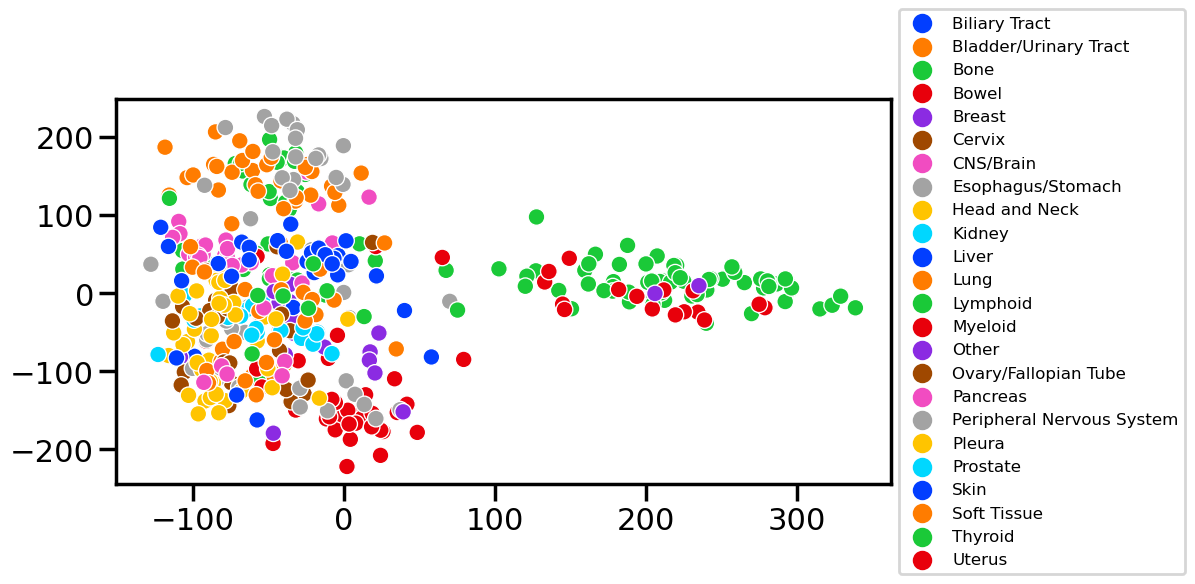

In [10]:
_ = plot_PCA(expr_df, n_components=10, hue=tissues)

# Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

## Collect the samples and responses for the drug

In [13]:
drug_name = 'Docetaxel'

In [14]:
samples = tissue_df.index.values
response_dict = response_df[drug_name].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [15]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.229496
1,Biliary Tract,EGI-1,0.027301
2,Biliary Tract,TGBC1TKB,0.055122
3,Biliary Tract,ETK-1,0.235336
4,Bladder/Urinary Tract,SW1710,0.181703
...,...,...,...
441,Thyroid,ASH-3,0.161333
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.135717
444,Thyroid,IHH-4,0.260577


## Drop all the NaN responses

In [16]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.229496
1,Biliary Tract,EGI-1,0.027301
2,Biliary Tract,TGBC1TKB,0.055122
3,Biliary Tract,ETK-1,0.235336
4,Bladder/Urinary Tract,SW1710,0.181703
...,...,...,...
440,Thyroid,WRO,0.104901
441,Thyroid,ASH-3,0.161333
443,Thyroid,HTC-C3,0.135717
444,Thyroid,IHH-4,0.260577


In [17]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [18]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,29,29
Breast,11,11
CNS/Brain,15,15
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [19]:
df['responses'].max(), df['responses'].min()

(0.430940178074287, 0.0139772413690281)

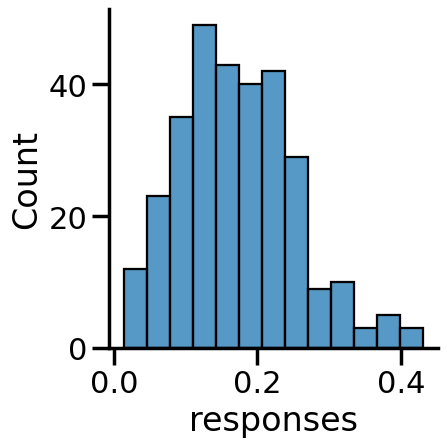

In [20]:
sns.displot(df['responses'])

In [21]:
df['responses'].mean(), df['responses'].median()

(0.17279479915578644, 0.164925267594393)

# Select baskets for analysis

Select some baskets

In [22]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

Use all baskets

In [23]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [24]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.229496
1,Biliary Tract,EGI-1,0.027301
2,Biliary Tract,TGBC1TKB,0.055122
3,Biliary Tract,ETK-1,0.235336
4,Bladder/Urinary Tract,SW1710,0.181703
...,...,...,...
298,Thyroid,WRO,0.104901
299,Thyroid,ASH-3,0.161333
300,Thyroid,HTC-C3,0.135717
301,Thyroid,IHH-4,0.260577


In [25]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((303, 19957), (446, 19957))

In [26]:
expr_df_filtered

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,3.205753,-9.965784,7.307272,-0.607968,0.481533,-9.965784,0.725387,5.847553,4.118905,4.821918,...,-6.475129,-6.749269,-9.965784,-9.965784,2.933364,-9.965784,-2.224737,-1.366209,-1.616199,-9.965784
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


In [27]:
drug_response = df_filtered.set_index('samples').drop(columns=['tissues'])
drug_response

,responses
samples,
TGBC24TKB,0.229496
EGI-1,0.027301
TGBC1TKB,0.055122
ETK-1,0.235336
SW1710,0.181703
...,...
WRO,0.104901
ASH-3,0.161333
HTC-C3,0.135717


## Feature selection using random forest

In [28]:
try: # try to load previously selected features
    fname = os.path.join('results', '%s_expr_df_selected.p' % drug_name)
    expr_df_selected = load_obj(fname)
    
except FileNotFoundError: # if not found, then re-run feature selection
    expr_df_selected = select_rf(expr_df_filtered, drug_response, n_splits=5, percentile_threshold=90, top_genes=500)
    save_obj(expr_df_selected, fname)

In [29]:
importance_df = check_rf(expr_df_selected, drug_response, test_size=0.2)

Test set results using selected features:
MSE: 0.005610301850483374
R^2: 0.3290217313953814


In [30]:
expr_df_selected

,ENSG00000087085.15,ENSG00000100353.18,ENSG00000106080.11,ENSG00000128203.7,ENSG00000129518.9,ENSG00000153310.19,ENSG00000159496.14,ENSG00000160191.18,ENSG00000171097.14,ENSG00000088387.19,...,ENSG00000118363.12,ENSG00000118855.21,ENSG00000119714.11,ENSG00000120149.9,ENSG00000120662.16,ENSG00000120686.12,ENSG00000120699.13,ENSG00000120885.22,ENSG00000121067.19,ENSG00000121101.15
TGBC24TKB,-1.488359,7.828958,3.222369,0.207871,4.729741,6.551517,-1.449346,-0.457157,4.164757,4.515712,...,7.535028,3.919286,-3.558991,6.813666,4.294419,5.126871,5.823440,7.027454,5.312538,-1.662541
EGI-1,-3.597939,7.691249,2.752279,1.225718,5.187351,6.158721,-1.006019,4.232133,4.301371,6.842691,...,7.437596,4.502653,2.379004,2.871238,4.417935,5.361334,5.444781,4.168388,5.822489,-0.949471
TGBC1TKB,-0.567522,7.647644,3.452910,1.241864,4.096392,6.255598,-1.347924,1.309242,2.281707,5.170906,...,8.126880,4.334643,-4.181515,2.460680,3.765419,5.205198,5.171663,4.323032,4.846360,-1.753218
ETK-1,-0.147366,7.076886,4.066674,0.308964,4.900237,7.166964,-2.262952,0.413956,2.018295,4.443640,...,7.524266,5.232804,0.311753,-1.892707,3.533109,4.525659,5.179682,4.576526,4.718725,-0.827075
SW1710,-4.040308,7.331458,3.897158,1.214325,4.485617,6.326129,-1.127516,2.257350,4.572155,3.644443,...,6.837013,4.648463,1.485283,-9.965784,3.255783,4.877554,4.496838,8.526298,4.979050,-0.839284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,-4.080836,8.486243,2.126377,0.593777,5.467867,5.534940,-1.616910,-4.804729,3.400414,5.050369,...,6.734176,3.589542,-3.887693,-9.965784,1.477741,5.860183,4.292178,4.039690,4.352914,-1.609019
ASH-3,-4.948490,8.285969,3.629065,2.046983,5.440072,5.109707,1.774833,-5.568976,3.810476,4.583850,...,6.987159,4.539537,3.745115,0.748136,3.675178,5.356144,5.287416,1.880460,4.819082,-0.027310
HTC-C3,-2.316761,8.082098,2.983069,0.605742,5.519269,5.747982,-1.741040,-7.027453,4.097008,7.133304,...,6.636683,5.633005,2.901546,-9.965784,4.417331,5.603408,5.203686,-0.941250,5.107695,-0.614788
IHH-4,-3.030080,8.673622,3.494538,0.203372,5.108066,4.968381,-1.006450,-4.598347,2.004973,7.147645,...,7.103800,5.211237,2.975887,-9.965784,4.848673,5.936185,5.566942,3.329870,5.036894,-0.311707


## Do PCA again on these samples

Before feature selection (using all 19957 transcripts)

PCA explained variance [0.13801374 0.23045013 0.29135664 0.32372722 0.34682604 0.36668807
 0.38184142 0.39640285 0.40971504 0.42171956]


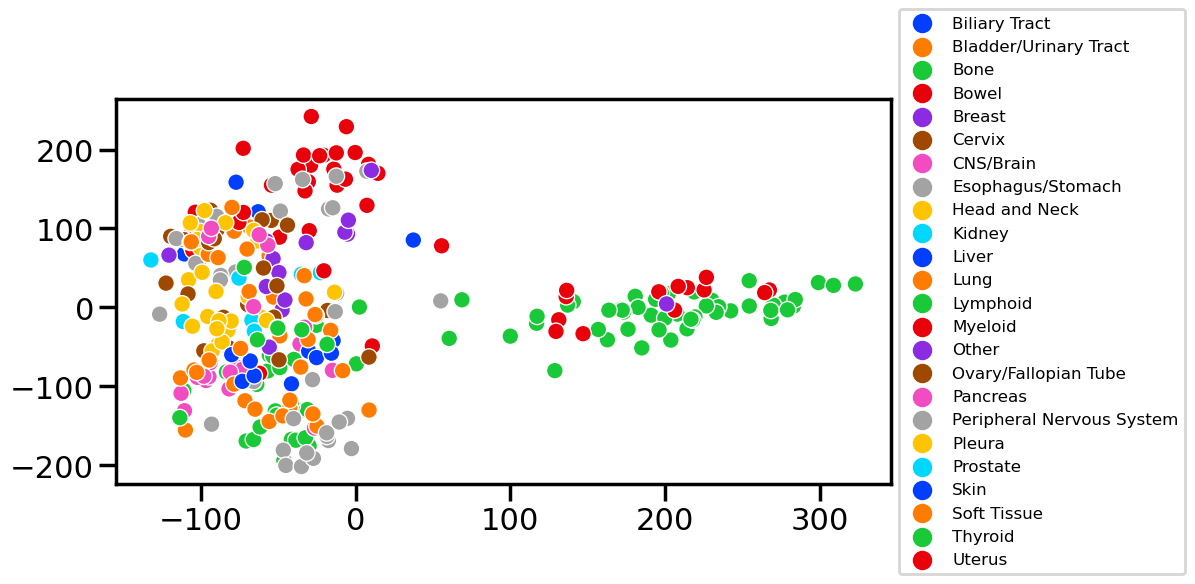

In [31]:
pc1, pc2 = plot_PCA(expr_df_filtered, n_components=10, hue=df_filtered['tissues'].values)

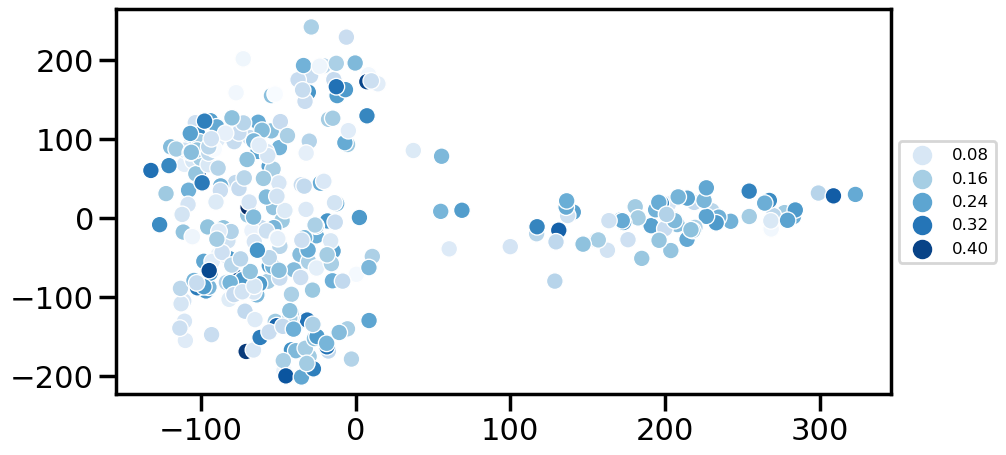

In [32]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

After feature selection (using 500 transcripts)

PCA explained variance [0.1297369  0.19969932 0.260079   0.301874   0.33328926 0.36026292
 0.38032791 0.39935341 0.41759842 0.43488062]


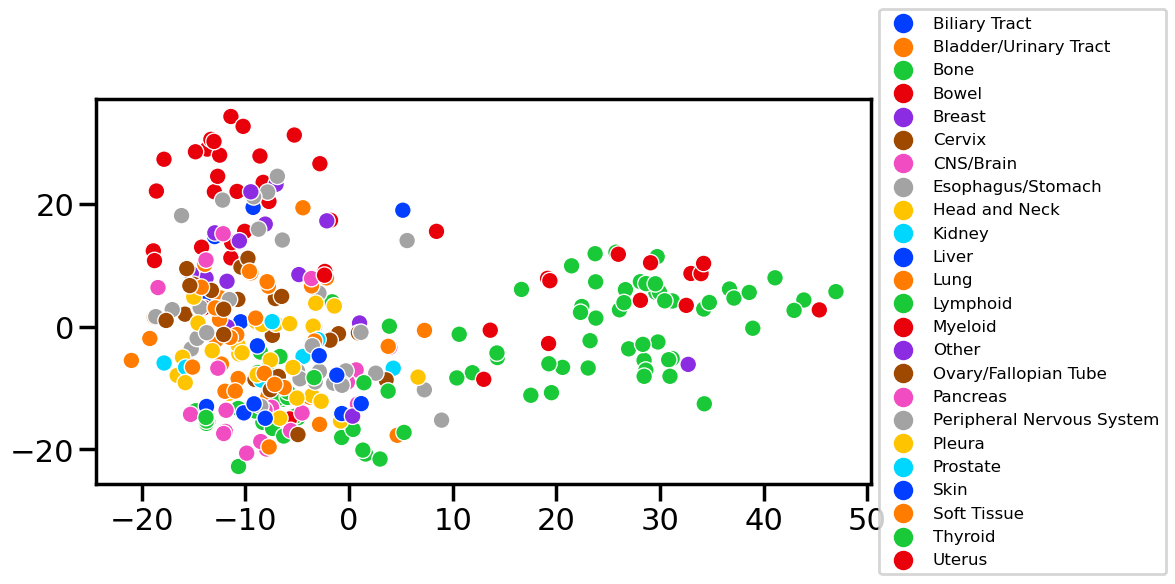

In [33]:
pc1, pc2 = plot_PCA(expr_df_selected, n_components=10, hue=df_filtered['tissues'].values)

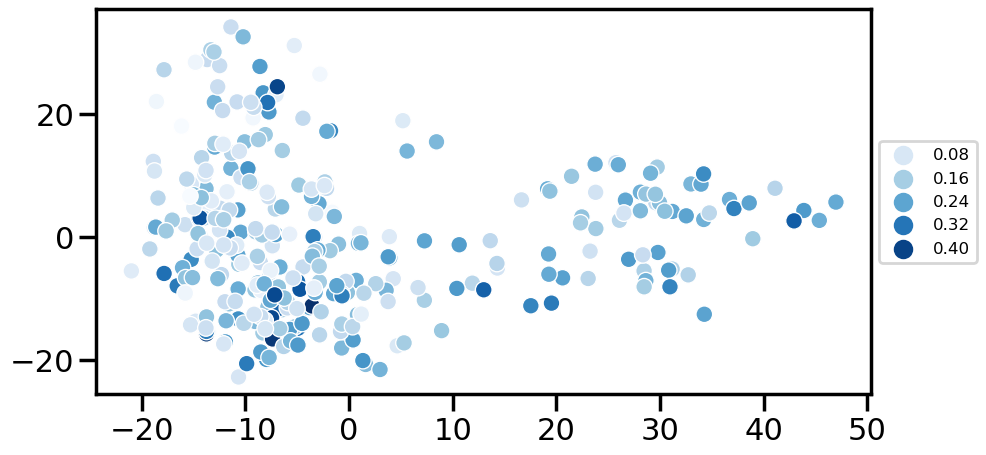

In [34]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

# Try clustering

In [35]:
expr_df_selected.shape

(303, 500)

In [36]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
TGBC24TKB,Biliary Tract,0.229496
EGI-1,Biliary Tract,0.027301
TGBC1TKB,Biliary Tract,0.055122
ETK-1,Biliary Tract,0.235336
SW1710,Bladder/Urinary Tract,0.181703
...,...,...
WRO,Thyroid,0.104901
ASH-3,Thyroid,0.161333
HTC-C3,Thyroid,0.135717


In [37]:
C = 10

In [38]:
kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_selected)

cluster_labels = kmeans.labels_
cluster_labels

array([7, 7, 2, 2, 3, 2, 3, 3, 2, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       3, 0, 9, 3, 0, 3, 0, 0, 3, 0, 0, 3, 5, 7, 5, 5, 7, 7, 5, 5, 5, 2,
       5, 7, 5, 5, 7, 4, 5, 5, 7, 3, 9, 5, 7, 7, 7, 7, 7, 5, 5, 8, 8, 8,
       8, 8, 8, 8, 9, 3, 2, 8, 2, 2, 2, 2, 9, 2, 3, 3, 2, 2, 3, 9, 2, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 2, 2, 3, 7, 7,
       2, 2, 5, 7, 2, 2, 5, 2, 4, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 7, 0, 9, 2, 9, 2, 9, 2, 9, 9, 9,
       7, 9, 2, 2, 9, 2, 0, 9, 9, 9, 9, 9, 9, 5, 9, 1, 1, 4, 4, 4, 4, 4,
       6, 6, 1, 1, 4, 6, 1, 1, 1, 1, 4, 1, 1, 1, 6, 1, 6, 1, 6, 1, 6, 6,
       1, 6, 4, 1, 4, 6, 4, 4, 6, 6, 4, 4, 4, 4, 1, 6, 6, 4, 3, 1, 6, 6,
       6, 6, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 3, 5, 6, 2, 2, 3, 3,
       2, 3, 2, 7, 3, 2, 7, 7, 2, 2, 7, 9, 9, 9, 9, 9, 9, 9, 9, 2, 9, 9,
       9, 3, 9, 9, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3,

PCA explained variance [0.1297369  0.19969932 0.260079   0.301874   0.33328926 0.36026292
 0.38032791 0.39935341 0.41759842 0.43488062]


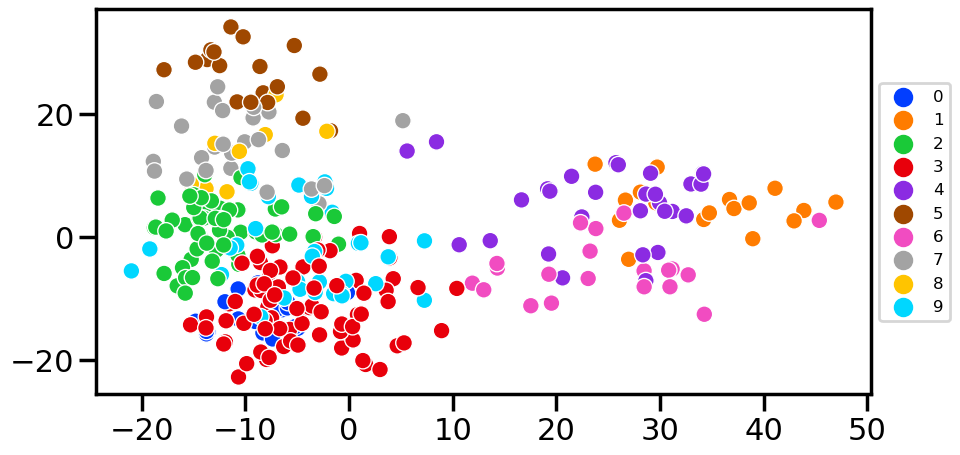

In [39]:
_ = plot_PCA(expr_df_selected, n_components=10, hue=cluster_labels)

# Run basket trial analysis

In [40]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [41]:
K = len(basket_names)
K, C

(24, 10)

Create clustering dataframe

In [42]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(303, 303)

In [43]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels, normalise=False)
cluster_df

,sk_0,sk_1,sk_2,sk_3,sk_4,sk_5,sk_6,sk_7,sk_8,sk_9
Biliary Tract,0,0,2,0,0,0,0,2,0,0
Bladder/Urinary Tract,0,0,2,3,0,0,0,0,0,0
Bone,15,0,0,9,0,0,0,0,0,1
Bowel,0,0,1,1,1,14,0,11,0,1
Breast,0,0,1,1,0,0,0,0,8,1
CNS/Brain,1,0,0,14,0,0,0,0,0,0
Cervix,0,0,8,3,0,0,0,0,0,2
Esophagus/Stomach,0,0,9,1,1,2,0,6,0,0
Head and Neck,0,0,13,3,0,0,0,0,0,0
Kidney,0,0,1,4,0,0,0,0,0,0


<AxesSubplot: >

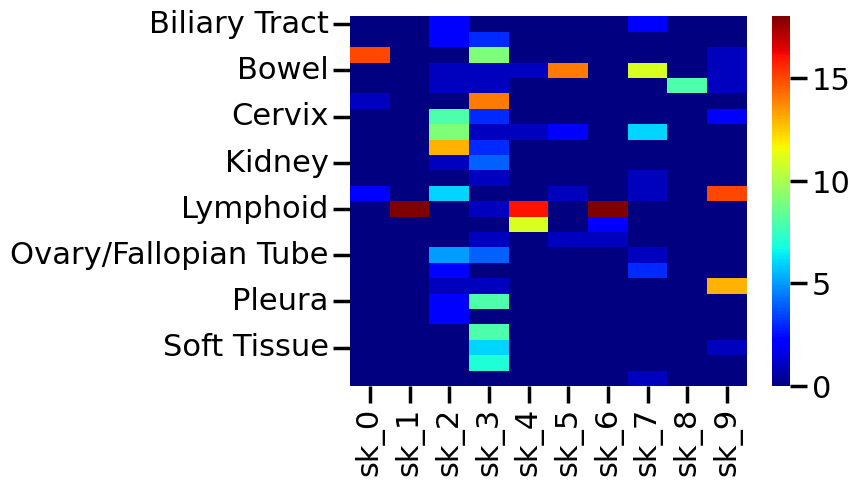

In [44]:
sns.heatmap(cluster_df, cmap='jet')

## Prepare patient data

In [45]:
patient_df = get_patient_df(df_filtered, cluster_labels)

In [46]:
patient_df

,tissues,responses,basket_number,cluster_number,responsive
samples,,,,,
TGBC24TKB,Biliary Tract,0.229496,0,7,0
EGI-1,Biliary Tract,0.027301,0,7,1
TGBC1TKB,Biliary Tract,0.055122,0,2,1
ETK-1,Biliary Tract,0.235336,0,2,0
SW1710,Bladder/Urinary Tract,0.181703,1,3,0
...,...,...,...,...,...
WRO,Thyroid,0.104901,22,3,1
ASH-3,Thyroid,0.161333,22,3,1
HTC-C3,Thyroid,0.135717,22,3,1


In [47]:
pivot_df = get_pivot_count_df(patient_df)
pivot_df

,n_success,n_trial
basket_number,,
0,2,4
1,2,5
2,10,25
3,19,29
4,6,11
5,5,13
6,3,15
7,9,19
8,5,16


In [48]:
data_df = patient_df
n_tissues = K
n_clusters = C

# Define models

No. of samples to collect before and after burn-in during MCMC.

In [49]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [50]:
model_s = get_model_simple_bern(data_df, n_tissues)

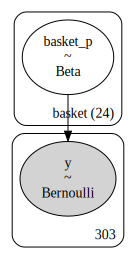

In [51]:
pm.model_to_graphviz(model_s)

In [52]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 52 seconds.


In [53]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[Biliary Tract],0.50,0.19,0.15,0.84,0.0,0.0,35355.0,12405.0,1.0
basket_p[Bladder/Urinary Tract],0.43,0.17,0.12,0.74,0.0,0.0,33131.0,13444.0,1.0
basket_p[Bone],0.41,0.10,0.23,0.59,0.0,0.0,32156.0,13196.0,1.0
basket_p[Bowel],0.64,0.08,0.49,0.80,0.0,0.0,34404.0,14088.0,1.0
basket_p[Breast],0.54,0.13,0.30,0.79,0.0,0.0,37014.0,14386.0,1.0
basket_p[Cervix],0.40,0.12,0.17,0.63,0.0,0.0,33555.0,13150.0,1.0
basket_p[CNS/Brain],0.24,0.10,0.06,0.42,0.0,0.0,29377.0,12152.0,1.0
basket_p[Esophagus/Stomach],0.48,0.11,0.28,0.68,0.0,0.0,32927.0,13629.0,1.0
basket_p[Head and Neck],0.33,0.11,0.14,0.55,0.0,0.0,31388.0,11827.0,1.0
basket_p[Kidney],0.57,0.17,0.26,0.89,0.0,0.0,31591.0,12882.0,1.0


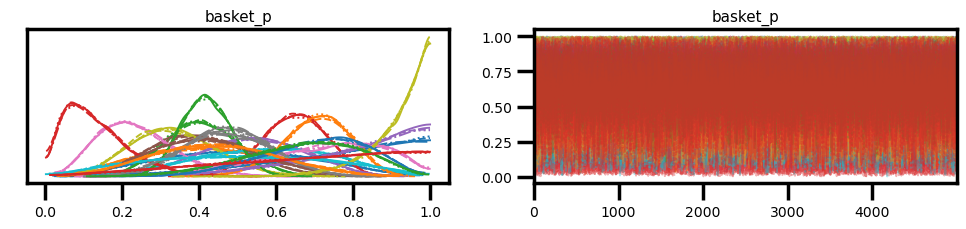

In [54]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

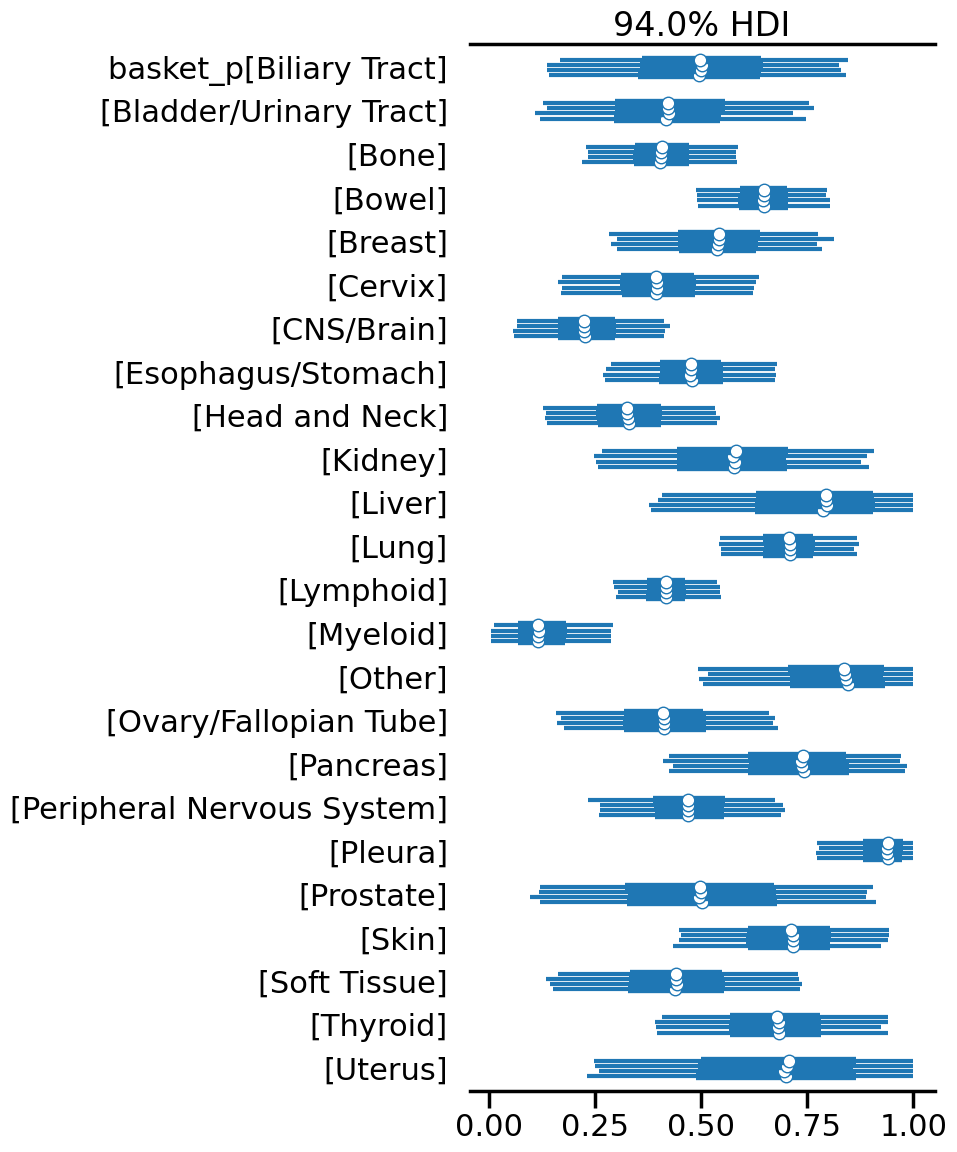

In [55]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [56]:
stacked_s = az.extract(trace_s)

In [57]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)

### pyBasket model

Another hierarchical model, but here we model the log-odds instead, so we can set Normal prior distributions on the parameters.

This is the model described in the paper, and it's what we shall use for further analysis.

In [58]:
model_pyBasket = get_model_pyBasket(data_df, n_tissues, n_clusters)

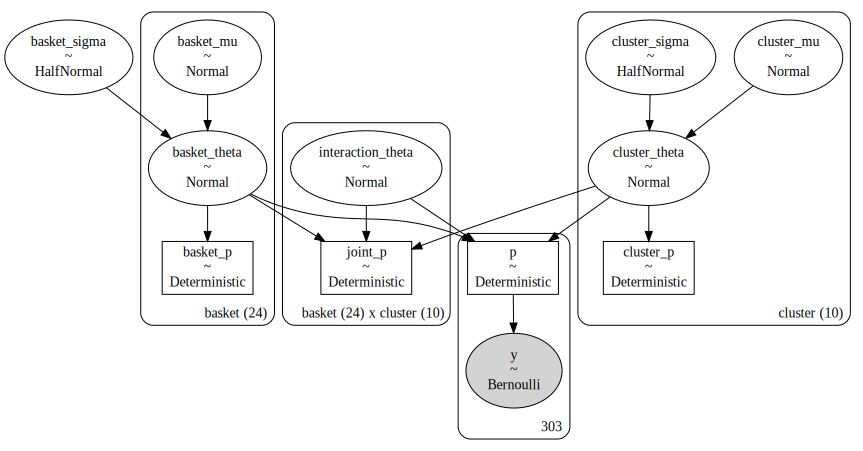

In [59]:
pm.model_to_graphviz(model_pyBasket)

In [60]:
# with model_pyBasket:
#     trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [61]:
model_pyBasket_nc = get_model_pyBasket_nc(data_df, n_tissues, n_clusters)

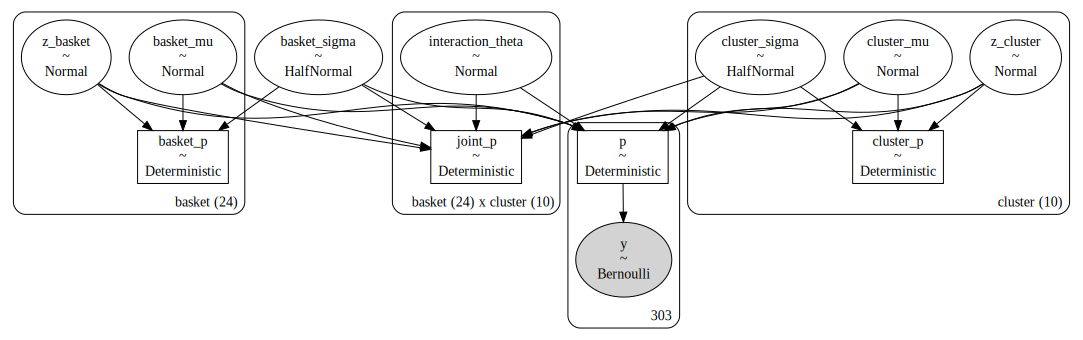

In [62]:
pm.model_to_graphviz(model_pyBasket_nc)

In [63]:
with model_pyBasket_nc:
    trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma, interaction_theta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 419 seconds.


In [64]:
az.summary(trace_pyBasket).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[Biliary Tract],-0.08,0.98,-1.92,1.77,0.0,0.01,40593.0,14905.0,1.0
z_basket[Bladder/Urinary Tract],-0.04,0.98,-1.91,1.80,0.0,0.01,46980.0,14505.0,1.0
z_basket[Bone],0.03,0.97,-1.70,1.96,0.0,0.01,34873.0,15372.0,1.0
z_basket[Bowel],-0.01,0.98,-1.83,1.85,0.0,0.01,36006.0,16016.0,1.0
z_basket[Breast],-0.06,0.97,-1.89,1.75,0.0,0.01,37653.0,15209.0,1.0
...,...,...,...,...,...,...,...,...,...
p[298],0.70,0.16,0.42,0.96,0.0,0.00,19961.0,14670.0,1.0
p[299],0.70,0.16,0.42,0.96,0.0,0.00,19961.0,14670.0,1.0
p[300],0.70,0.16,0.42,0.96,0.0,0.00,19961.0,14670.0,1.0
p[301],0.70,0.16,0.42,0.96,0.0,0.00,19961.0,14670.0,1.0


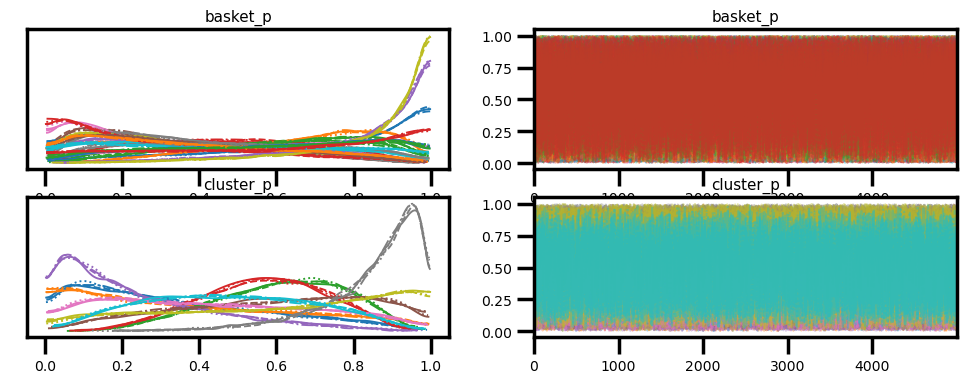

In [65]:
az.plot_trace(trace_pyBasket, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

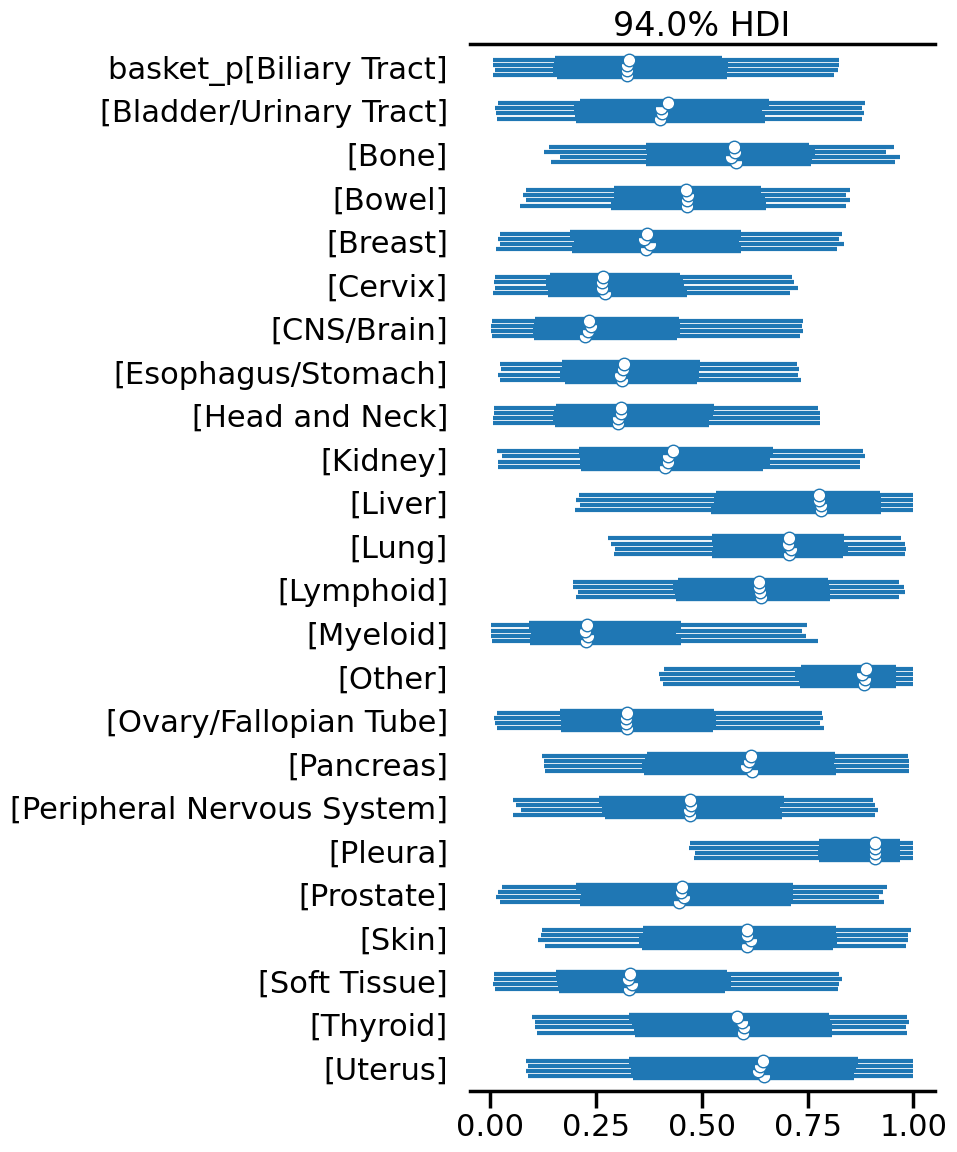

In [66]:
az.plot_forest(trace_pyBasket, var_names=['basket_p'])

In [67]:
stacked_pyBasket = az.extract(trace_pyBasket)

In [68]:
inferred_basket_p = np.mean(stacked_pyBasket.basket_p.values, axis=1)

In [69]:
inferred_cluster_p = np.mean(stacked_pyBasket.cluster_p.values, axis=1)

In [78]:
inferred_joint_p = np.mean(stacked_pyBasket.joint_p.values, axis=2)

### Compare the matrices

In [71]:
sns.set_context('poster')

In [72]:
predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})

predicted_basket_pyBasket = np.mean(stacked_pyBasket.basket_p.values, axis=1)
predicted_basket_pyBasket_df = pd.DataFrame({'prob': predicted_basket_pyBasket, 'basket': range(len(predicted_basket_pyBasket))})

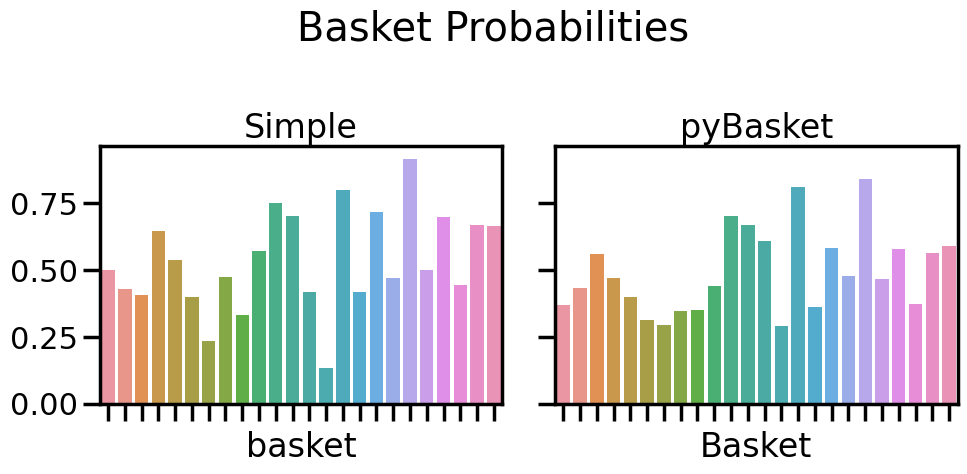

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('Simple')
ax[0].set_ylabel('Probability')
ax[0].set_ylabel(None)

sns.barplot(data=predicted_basket_pyBasket_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('pyBasket')
ax[1].set_ylabel(None)
ax[1].set_xticklabels([])
ax[1].set_xlabel('Basket')

plt.suptitle('Basket Probabilities')
plt.tight_layout()
plt.savefig(f'results/report_{drug_name}_10_basket_probs.png', dpi=300)

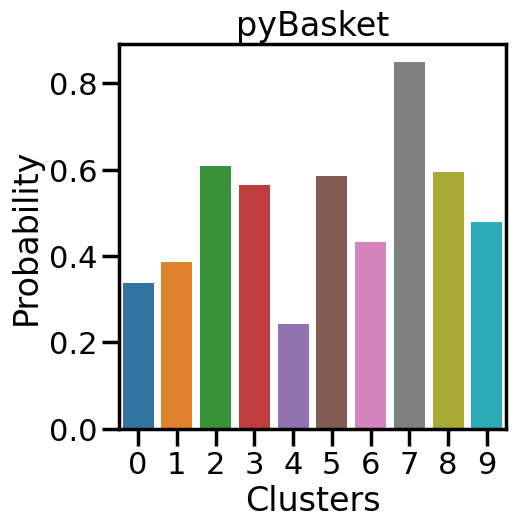

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

# Convert data to pandas Series
clusters = pd.Series(range(len(inferred_cluster_p)))
predicted_cluster_pyBasket = pd.Series(inferred_cluster_p)

sns.barplot(x=clusters, y=predicted_cluster_pyBasket, ax=ax)

ax.set_title('pyBasket')
ax.set_xlabel('Clusters')
ax.set_ylabel('Probability')

plt.savefig(f'results/report_{drug_name}_10_cluster_probs.png', dpi=300)


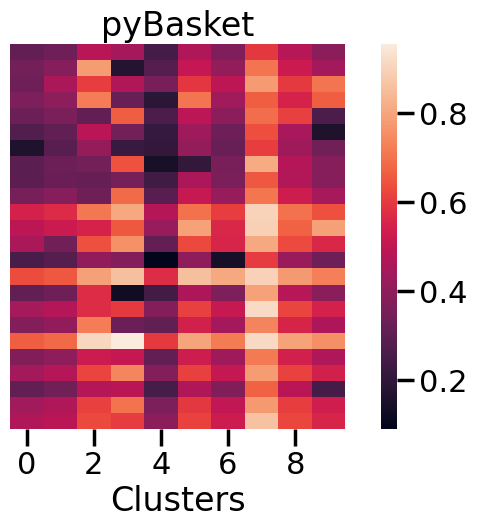

In [84]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05]) 
ax0 = plt.subplot(gs[0])
cbar_ax = plt.subplot(gs[1])

sns.heatmap(inferred_joint_p, ax=ax0, cbar_ax=cbar_ax)
ax0.set_title('pyBasket')
ax0.set_xlabel('Clusters')
ax0.set_yticks([]) # Hide yticklabels

plt.savefig(f'results/report_{drug_name}_10_joint_prob.png', dpi=300)

## 4. Model comparison

In [85]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [86]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 303 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -202.83     5.98
p_loo       19.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      299   98.7%
 (0.5, 0.7]   (ok)          4    1.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [87]:
loo_pyBasket = az.loo(trace_pyBasket)
loo_pyBasket

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 303 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -209.36     8.58
p_loo       45.93        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      265   87.5%
 (0.5, 0.7]   (ok)         34   11.2%
   (0.7, 1]   (bad)         4    1.3%
   (1, Inf)   (very bad)    0    0.0%

In [88]:
ic = 'loo'
df_comp_loo = az.compare({
    'Simple': loo_s, 
    'pyBasket': loo_pyBasket,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Simple,0,-202.832741,19.196054,0.000000,0.754298,5.977241,0.00000,False,log
pyBasket,1,-209.364696,45.929554,6.531955,0.245702,8.578338,5.12902,True,log


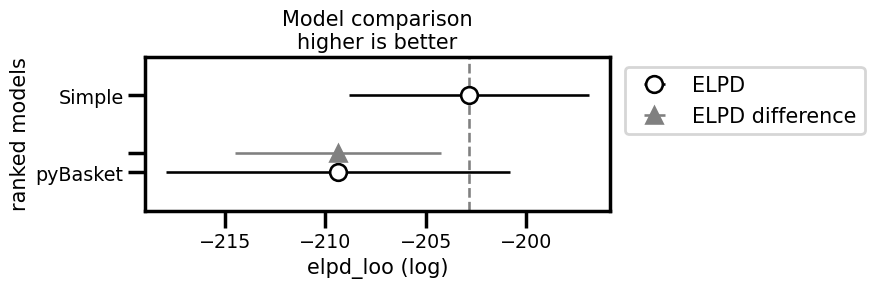

In [89]:
az.plot_compare(df_comp_loo);